In [2]:
# ruff: noqa: F401, E402
import math
import sys
from bisect import bisect_left, bisect_right
from collections import Counter, deque
from functools import cmp_to_key, lru_cache, reduce
from heapq import heapify, heappop, heappush, heappushpop, nsmallest
from importlib import reload
from itertools import (
    accumulate,
    chain,
    combinations,
    islice,
    pairwise,
    permutations,
    product,
    starmap,
    tee,
)
from math import comb, factorial, log, sqrt
from operator import add, and_, contains, indexOf, itemgetter, neg, or_, xor
from pprint import pprint
from typing import Callable, Iterable, List, Tuple

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import arrays
import graphs
import lists
import mathematics
import matrix
import parsing
import search
import sequences
import sets
import strings
import trees

for m in (
    arrays,
    graphs,
    lists,
    mathematics,
    matrix,
    parsing,
    search,
    sequences,
    sets,
    strings,
    trees,
):
    reload(m)


from parsing import format_binop_expression, parse_binop_expression
from sequences import find_if
from strings import StringView, splint

print()


In [29]:
def tarjans(adj: List[List[int]]) -> List[List[int]]:
    "Return strongly connected components as list of vertices."

    vt = [0] * len(adj)  # visit time
    ct = vt[:]  # circle time
    on_stack = vt[:]
    stack = []
    t = 1
    ccs = []

    def dfs(n, d):
        nonlocal t
        ct[n] = vt[n] = t
        print(f"{'  '*d}> {n}: vt: {vt[n]}, ct: {ct[n]}, s: {stack}")
        t += 1
        on_stack[n] = 1
        stack.append(n)
        for c in adj[n]:
            if not vt[c]:
                dfs(c, d + 1)
                ct[n] = min(ct[n], ct[c])
            elif on_stack[c]:
                ct[n] = min(ct[n], vt[c])

        print(f"{'  '*d}< {n}: vt: {vt[n]}, ct: {ct[n]}, s: {stack}")
        if vt[n] == ct[n]:
            cc = [stack.pop()]
            on_stack[cc[-1]] = 0
            while cc[-1] != n:
                cc.append(stack.pop())
                on_stack[cc[-1]] = 0
            print(f"{'  '*d}+ cc: {cc}")
            ccs.append(cc)

    for i in range(len(vt)):
        if not vt[i]:
            print("-" * 40)
            print(i)
            dfs(i, 0)
            print(f"vt: {vt}")
            print(f"ct: {ct}")

    for cc in ccs:
        cc.sort()
    ccs.sort()

    return ccs


In [32]:
def tarjans(adj: List[List[int]]) -> List[List[int]]:
    "Return strongly connected components as list of vertices."
    vt = [0] * len(adj)  # visit time
    ct = vt[:]  # circle time
    on_stack = vt[:]
    stack = []
    t = 1
    ccs = []  # result

    def dfs(n):
        nonlocal t
        ct[n] = vt[n] = t
        t += 1
        on_stack[n] = 1
        stack.append(n)
        for c in adj[n]:
            if not vt[c]:
                dfs(c)
                # Direct tree edge
                ct[n] = min(ct[n], ct[c])
            elif on_stack[c]:
                # Back edge
                ct[n] = min(ct[n], vt[c])
            # else: cross edge

        if vt[n] == ct[n]:
            # `n` is the root node of the SCC.
            cc = [stack.pop()]
            on_stack[cc[-1]] = 0
            while cc[-1] != n:
                cc.append(stack.pop())
                on_stack[cc[-1]] = 0
            cc.sort()
            ccs.append(cc)

    for i, visited in enumerate(vt):
        if not visited:
            dfs(i)

    ccs.sort()
    return ccs


In [ ]:
adj = []


In [19]:
tarjans(adj)


----------------------------------------
0
> 0: vt: 1, ct: 1, s: []
  > 9: vt: 2, ct: 2, s: [0]
    > 5: vt: 3, ct: 3, s: [0, 9]
      > 4: vt: 4, ct: 4, s: [0, 9, 5]
      < 4: vt: 4, ct: 3, s: [0, 9, 5, 4]
    < 5: vt: 3, ct: 1, s: [0, 9, 5, 4]
  < 9: vt: 2, ct: 1, s: [0, 9, 5, 4]
  > 3: vt: 5, ct: 5, s: [0, 9, 5, 4]
  < 3: vt: 5, ct: 5, s: [0, 9, 5, 4, 3]
  + cc: [3]
  > 8: vt: 6, ct: 6, s: [0, 9, 5, 4]
    > 6: vt: 7, ct: 7, s: [0, 9, 5, 4, 8]
    < 6: vt: 7, ct: 7, s: [0, 9, 5, 4, 8, 6]
    + cc: [6]
  < 8: vt: 6, ct: 3, s: [0, 9, 5, 4, 8]
< 0: vt: 1, ct: 1, s: [0, 9, 5, 4, 8]
+ cc: [8, 4, 5, 9, 0]
vt: [1, 0, 0, 5, 4, 3, 7, 0, 6, 2]
ct: [1, 0, 0, 5, 3, 1, 7, 0, 3, 1]
----------------------------------------
1
> 1: vt: 8, ct: 8, s: []
< 1: vt: 8, ct: 8, s: [1]
+ cc: [1]
vt: [1, 8, 0, 5, 4, 3, 7, 0, 6, 2]
ct: [1, 8, 0, 5, 3, 1, 7, 0, 3, 1]
----------------------------------------
2
> 2: vt: 9, ct: 9, s: []
< 2: vt: 9, ct: 9, s: [2]
+ cc: [2]
vt: [1, 8, 9, 5, 4, 3, 7, 0, 6, 2]
ct: [1

[[0, 4, 5, 8, 9], [1], [2], [3], [6], [7]]

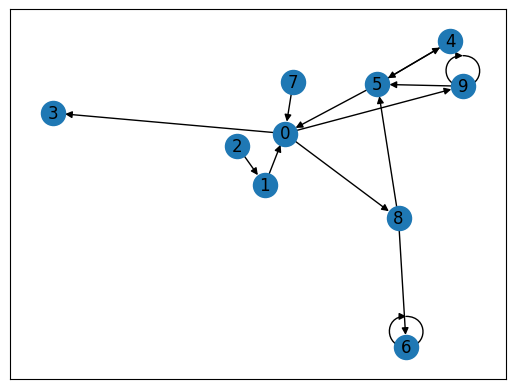

In [18]:
adj = [[9, 3, 8],  [0], [1], [],[5], [4, 0], [6], [0], [5, 6], [5, 9]]
g = nx.DiGraph(dict(enumerate(adj)))
nx.draw_networkx(g)


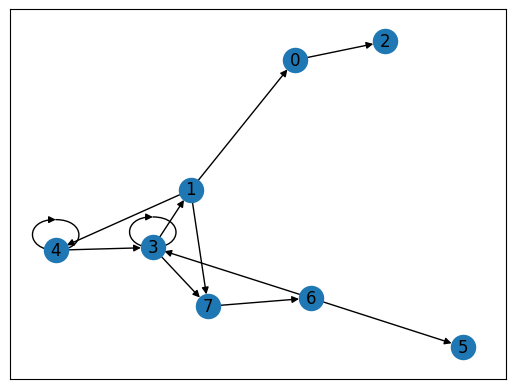

In [27]:
adj = [[2], [4, 7, 0], [], [1, 7, 3], [4, 3], [], [3, 5], [6]]
g = nx.DiGraph(dict(enumerate(adj)))
nx.draw_networkx(g)


In [28]:
tarjans(adj)


----------------------------------------
0
> 0: vt: 1, ct: 1, s: []
  > 2: vt: 2, ct: 2, s: [0]
  < 2: vt: 2, ct: 2, s: [0, 2]
  + cc: [2]
< 0: vt: 1, ct: 1, s: [0]
+ cc: [0]
vt: [1, 0, 2, 0, 0, 0, 0, 0]
ct: [1, 0, 2, 0, 0, 0, 0, 0]
----------------------------------------
1
> 1: vt: 3, ct: 3, s: []
  > 4: vt: 4, ct: 4, s: [1]
    > 3: vt: 5, ct: 5, s: [1, 4]
      > 7: vt: 6, ct: 6, s: [1, 4, 3]
        > 6: vt: 7, ct: 7, s: [1, 4, 3, 7]
          > 5: vt: 8, ct: 8, s: [1, 4, 3, 7, 6]
          < 5: vt: 8, ct: 8, s: [1, 4, 3, 7, 6, 5]
          + cc: [5]
        < 6: vt: 7, ct: 5, s: [1, 4, 3, 7, 6]
      < 7: vt: 6, ct: 5, s: [1, 4, 3, 7, 6]
    < 3: vt: 5, ct: 3, s: [1, 4, 3, 7, 6]
  < 4: vt: 4, ct: 3, s: [1, 4, 3, 7, 6]
< 1: vt: 3, ct: 3, s: [1, 4, 3, 7, 6]
+ cc: [6, 7, 3, 4, 1]
vt: [1, 3, 2, 5, 4, 8, 7, 6]
ct: [1, 3, 2, 3, 3, 8, 5, 5]


[[0], [1, 3, 4, 6, 7], [2], [5]]

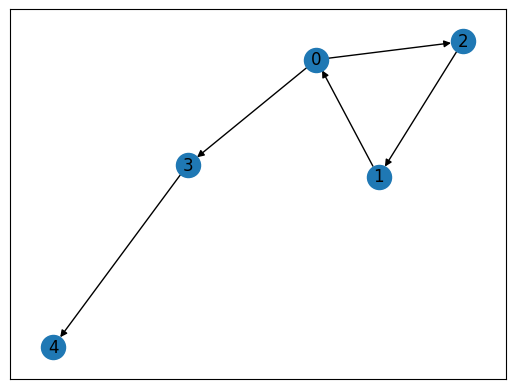

In [33]:
adj = [[2, 3], [0], [1], [4], []]
g = nx.DiGraph(dict(enumerate(adj)))
nx.draw_networkx(g)


In [34]:
tarjans(adj)


[[0, 1, 2], [3], [4]]